In [182]:
# Import required libraries
import pandas as pd

import sys
import os

# Get the path of the parent directory (project)
parent_dir = os.path.abspath(os.path.join(os.getcwd(), os.pardir))

# Add the folder containing the .py file to sys.path
sys.path.append(os.path.join(parent_dir, 'utils'))

from preprocessing import load_and_clean_data, encode_and_scale
from model import build_kmeans_model, build_deep_learning_model
from evaluation import evaluate_kmeans_model, plot_clusters, plot_confusion_matrix

# Load and clean the data
file_path = '../data/marketing_campaign.xlsx'
df = load_and_clean_data(file_path)
df




/Users/foumiakhalid/code/customer_segmentation/utils/preprocessing.py:10: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['Income'].fillna(df['Income'].median(), inplace=True)


,Year_Birth,Education,Marital_Status,Income,Kidhome,Teenhome,Recency,MntWines,MntFruits,MntMeatProducts,...,NumWebVisitsMonth,AcceptedCmp3,AcceptedCmp4,AcceptedCmp5,AcceptedCmp1,AcceptedCmp2,Complain,Response,Customer_Since,Total_Children
0,1957,Graduation,Single,58138.0,0,0,58,635,88,546,...,7,0,0,0,0,0,0,1,4401,0
1,1954,Graduation,Single,46344.0,1,1,38,11,1,6,...,5,0,0,0,0,0,0,0,3851,2
2,1965,Graduation,Together,71613.0,0,0,26,426,49,127,...,4,0,0,0,0,0,0,0,4050,0
3,1984,Graduation,Together,26646.0,1,0,26,11,4,20,...,6,0,0,0,0,0,0,0,3877,1
4,1981,PhD,Married,58293.0,1,0,94,173,43,118,...,5,0,0,0,0,0,0,0,3899,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2235,1967,Graduation,Married,61223.0,0,1,46,709,43,182,...,5,0,0,0,0,0,0,0,4119,1
2236,1946,PhD,Together,64014.0,2,1,56,406,0,30,...,7,0,0,0,1,0,0,0,3757,3
2237,1981,Graduation,Divorced,56981.0,0,0,91,908,48,217,...,6,0,1,0,0,0,0,0,3893,0
2238,1956,Master,Together,69245.0,0,1,8,428,30,214,...,3,0,0,0,0,0,0,0,3894,1


In [183]:
from sklearn.model_selection import train_test_split

# Preprocess, encode, and scale the data
df_cleaned = encode_and_scale(df)
df_cleaned

# Split the data into training and testing sets
X = df_cleaned.drop('Response', axis=1)
y = df_cleaned['Response']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

Silhouette Score: 0.3720963353519851


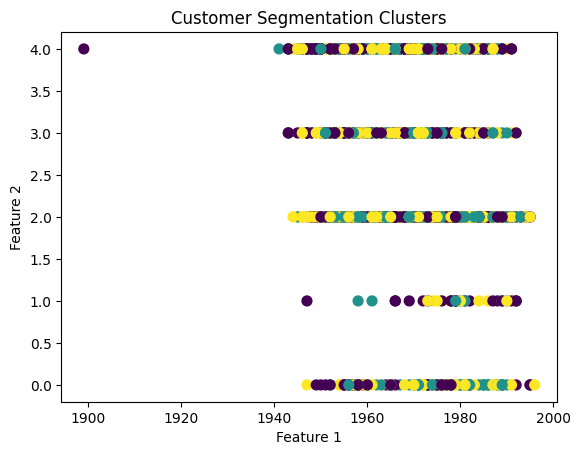

In [184]:
# Build the model
# Option 1: Use KMeans for Clustering
kmeans_model = build_kmeans_model(X_train)

# Evaluate the model
labels = evaluate_kmeans_model(kmeans_model, X_train)

# Visualize the clusters
plot_clusters(X_train.to_numpy(), labels)

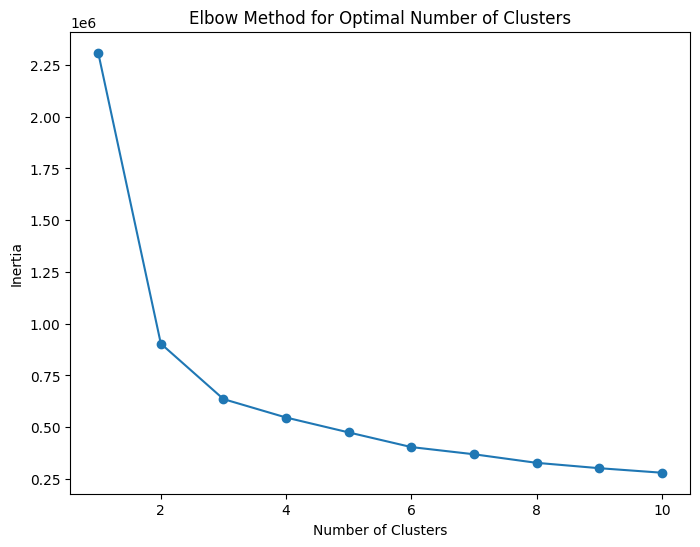

In [185]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

def elbow_method(X):
    # Range of values to test for n_clusters
    inertia = []
    cluster_range = range(1, 11)

    for k in cluster_range:
        kmeans = KMeans(n_clusters=k, random_state=42, init='k-means++')
        kmeans.fit(X)
        inertia.append(kmeans.inertia_)

    # Plot the elbow curve
    plt.figure(figsize=(8, 6))
    plt.plot(cluster_range, inertia, marker='o')
    plt.title('Elbow Method for Optimal Number of Clusters')
    plt.xlabel('Number of Clusters')
    plt.ylabel('Inertia')
    plt.show()

# Example usage:
# X is your data (e.g., scaled features)
elbow_method(X)


Test Accuracy: 85.86%


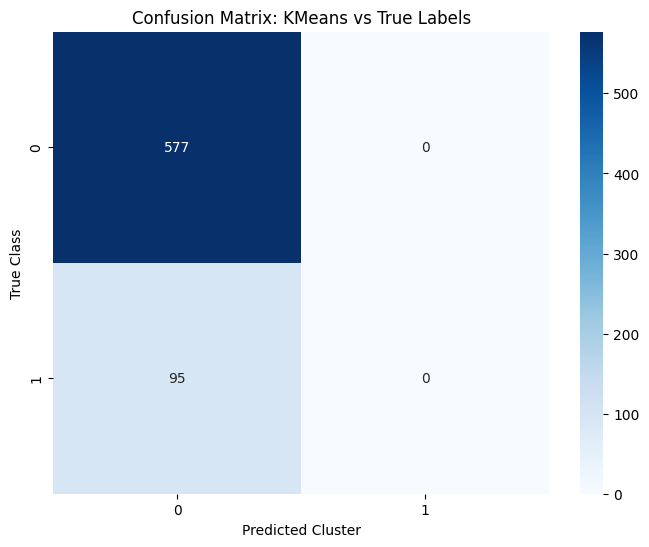

In [186]:
# Confusion matrix
# Predict cluster labels on the test data
from scipy.stats import mode
import seaborn as sns
from sklearn.metrics import accuracy_score, confusion_matrix

cluster_labels = kmeans_model.predict(X_test)

# Map cluster labels to true labels using majority voting within clusters
# This step ensures that cluster labels correspond to the true classes

def map_clusters_to_labels(cluster_labels, true_labels):
    # Initialize an empty array to store the mapped labels
    mapped_labels = np.zeros_like(cluster_labels)
    
    for cluster in np.unique(cluster_labels):
        # Find the true labels within each cluster
        mask = (cluster_labels == cluster)
        # Assign the most frequent true label in each cluster to that cluster
        mapped_labels[mask] = mode(true_labels[mask])[0]
    
    return mapped_labels

# Apply the mapping
mapped_cluster_labels = map_clusters_to_labels(cluster_labels, y_test)

# Evaluate accuracy
accuracy = accuracy_score(y_test, mapped_cluster_labels)
print(f"Test Accuracy: {accuracy * 100:.2f}%")

# Generate the confusion matrix
cm = confusion_matrix(y_test, mapped_cluster_labels)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix: KMeans vs True Labels')
plt.xlabel('Predicted Cluster')
plt.ylabel('True Class')
plt.show()

In [187]:
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score

# Assume X is the feature matrix
kmeans_model = build_kmeans_model(X, n_clusters=3)

# Inertia (Within-Cluster Sum of Squares)
inertia = kmeans_model.inertia_
print(f"Inertia: {inertia}")

# Predict cluster labels
cluster_labels = kmeans_model.predict(X)

# Silhouette Score (range: -1 to 1, higher is better)
silhouette = silhouette_score(X, cluster_labels)
print(f"Silhouette Score: {silhouette}")

# Calinski-Harabasz Index (higher is better)
calinski_harabasz = calinski_harabasz_score(X, cluster_labels)
print(f"Calinski-Harabasz Index: {calinski_harabasz}")

# Davies-Bouldin Index (lower is better)
davies_bouldin = davies_bouldin_score(X, cluster_labels)
print(f"Davies-Bouldin Index: {davies_bouldin}")

X.head()


Inertia: 635529.292218148
Silhouette Score: 0.3736617583320291
Calinski-Harabasz Index: 2944.969065954121
Davies-Bouldin Index: 0.952444311163655


,Year_Birth,Education,Marital_Status,Income,Kidhome,Teenhome,Recency,MntWines,MntFruits,MntMeatProducts,...,NumStorePurchases,NumWebVisitsMonth,AcceptedCmp3,AcceptedCmp4,AcceptedCmp5,AcceptedCmp1,AcceptedCmp2,Complain,Customer_Since,Total_Children
0,1957,2,4,0.235696,0,0,58,0.983781,1.551577,1.679702,...,4,7,0,0,0,0,0,0,1.531185,-1.264505
1,1954,2,4,-0.235454,1,1,38,-0.870479,-0.636301,-0.713225,...,2,5,0,0,0,0,0,0,-1.190545,1.396361
2,1965,2,5,0.773999,0,0,26,0.362723,0.570804,-0.177032,...,10,4,0,0,0,0,0,0,-0.205773,-1.264505
3,1984,2,5,-1.022355,1,0,26,-0.870479,-0.560857,-0.651187,...,4,6,0,0,0,0,0,0,-1.061881,0.065928
4,1981,4,3,0.241888,1,0,94,-0.389085,0.419916,-0.216914,...,6,5,0,0,0,0,0,0,-0.953012,0.065928


In [188]:
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam

# Build the model
model = build_deep_learning_model(X_train, y_train)

# Train the model
history = model.fit(X_train, y_train, 
                    epochs=50, 
                    batch_size=32, 
                    validation_split=0.2, 
                    verbose=2)


Epoch 1/50


/opt/homebrew/yes/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6427 - loss: 53.9120 - val_accuracy: 0.8408 - val_loss: 33.8156
Epoch 2/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 601us/step - accuracy: 0.7757 - loss: 25.6524 - val_accuracy: 0.8408 - val_loss: 11.6170
Epoch 3/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 566us/step - accuracy: 0.7453 - loss: 18.8832 - val_accuracy: 0.8408 - val_loss: 7.9145
Epoch 4/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 558us/step - accuracy: 0.7689 - loss: 12.1323 - val_accuracy: 0.8408 - val_loss: 5.9183
Epoch 5/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 569us/step - accuracy: 0.7303 - loss: 12.1092 - val_accuracy: 0.8408 - val_loss: 3.2667
Epoch 6/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 559us/step - accuracy: 0.7708 - loss: 9.2419 - val_accuracy: 0.8408 - val_loss: 1.1082
Epoch 7/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 573us/step - accuracy: 0.7610 - loss: 6.2518 - val_accuracy: 0.1592 - val_loss: 3.9517
Epoch 8/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 584us/step - accuracy: 0.7351 - loss: 5.8379 - val_accuracy: 0.8408 -

21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 266us/step
Test Accuracy: 88.10%


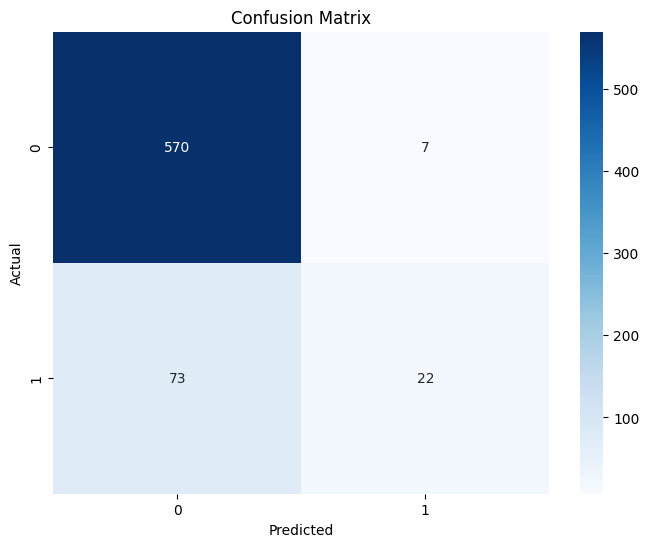

              precision    recall  f1-score   support

           0       0.89      0.99      0.93       577
           1       0.76      0.23      0.35        95

    accuracy                           0.88       672
   macro avg       0.82      0.61      0.64       672
weighted avg       0.87      0.88      0.85       672



In [189]:
# Evaluate the model on the test set
y_pred_probs = model.predict(X_test)
y_pred = np.argmax(y_pred_probs, axis=1)  # Convert probabilities to class labels

# Accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Test Accuracy: {accuracy * 100:.2f}%")

# Confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# Classification report
print(classification_report(y_test, y_pred))


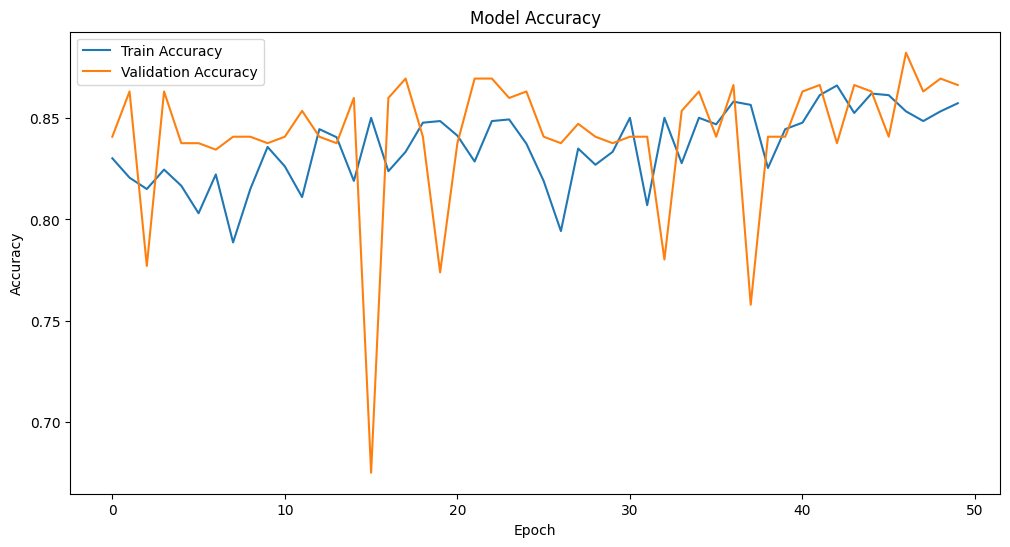

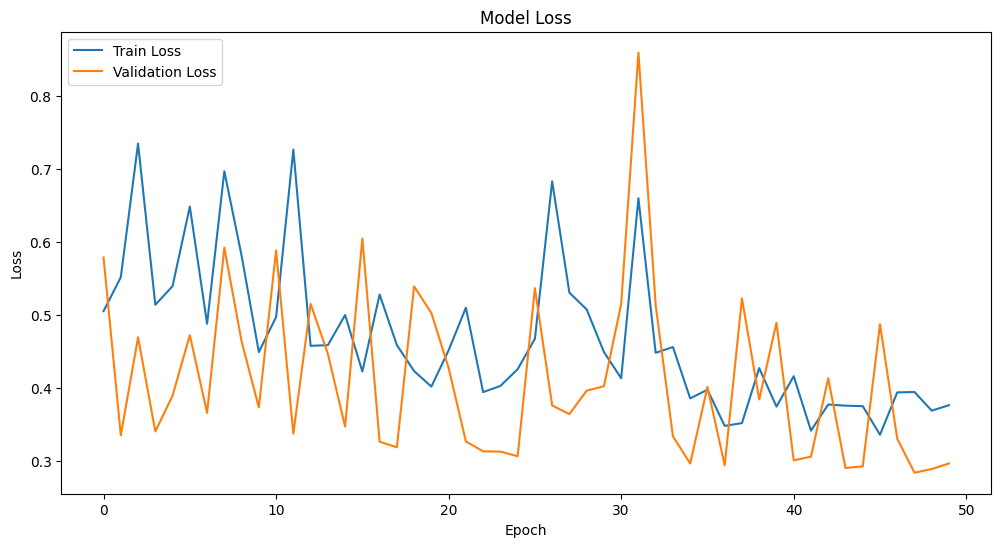

In [190]:
# Plot training & validation accuracy values
plt.figure(figsize=(12, 6))
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc='upper left')
plt.show()

# Plot training & validation loss values
plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper left')
plt.show()


In [193]:
import kerastuner as kt

# Function to build the model for Keras Tuner
def build_tuned_model(hp):
    model = Sequential()

    # Tune number of neurons in the first Dense layer
    model.add(Dense(units=hp.Int('units', min_value=32, max_value=128, step=32), 
                    activation='relu', input_dim=X_train.shape[1]))

    # Tune the number of hidden layers and units
    for i in range(hp.Int('num_layers', 1, 3)):
        model.add(Dense(units=hp.Int(f'layer_{i}_units', min_value=32, max_value=128, step=32),
                        activation='relu'))
        model.add(Dropout(rate=hp.Float(f'dropout_rate_{i}', min_value=0.2, max_value=0.5, step=0.1)))

    model.add(Dense(3, activation='softmax'))  # 3 output classes for classification

    # Tune learning rate
    learning_rate = hp.Float('learning_rate', min_value=1e-4, max_value=1e-2, sampling='LOG')
    model.compile(optimizer=Adam(learning_rate=learning_rate),
                  loss='sparse_categorical_crossentropy', 
                  metrics=['accuracy'])
    
    return model


In [194]:
# Instantiate the tuner
tuner = kt.RandomSearch(
    build_tuned_model,  # Hypermodel
    objective='val_accuracy',  # Optimize for validation accuracy
    max_trials=10,  # Number of different hyperparameter combinations to try
    executions_per_trial=1,  # Number of model builds and fits to do per trial
    directory='my_dir',  # Directory to save results
    project_name='customer_segmentation'
)

# Run the search for the best hyperparameters
tuner.search(X_train, y_train, epochs=50, validation_split=0.2, verbose=2)

# Get the best hyperparameters and model
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
print(f"Best Hyperparameters: {best_hps.values}")

# Build and retrain the model with the best hyperparameters
best_model = tuner.hypermodel.build(best_hps)
best_model.fit(X_train, y_train, epochs=50, validation_split=0.2)


Reloading Tuner from my_dir/customer_segmentation/tuner0.json
Best Hyperparameters: {'units': 32, 'num_layers': 1, 'layer_0_units': 128, 'dropout_rate_0': 0.30000000000000004, 'learning_rate': 0.0013960944101282333}
Epoch 1/50


/opt/homebrew/yes/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7269 - loss: 30.6392 - val_accuracy: 0.8408 - val_loss: 9.8321
Epoch 2/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 634us/step - accuracy: 0.7522 - loss: 13.1046 - val_accuracy: 0.8408 - val_loss: 3.4760
Epoch 3/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 575us/step - accuracy: 0.7508 - loss: 6.1281 - val_accuracy: 0.8408 - val_loss: 3.0749
Epoch 4/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 580us/step - accuracy: 0.7415 - loss: 3.1365 - val_accuracy: 0.8408 - val_loss: 2.0286
Epoch 5/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 561us/step - accuracy: 0.7885 - loss: 1.6623 - val_accuracy: 0.8408 - val_loss: 0.4393
Epoch 6/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 569us/step - accuracy: 0.8413 - loss: 0.5213 - val_accuracy: 0.8408 - val_loss: 0.4456
Epoch 7/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 566us/step - accuracy: 0.8449 - loss: 0.4751 - val_accuracy: 0.8408 - val_loss: 0.4228
Epoch 8/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 558us/step - accuracy: 0.8408 - loss: 0.4543 - val_accuracy: 0.8408 - val_

21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 290us/step
Tuned Model Test Accuracy: 85.86%


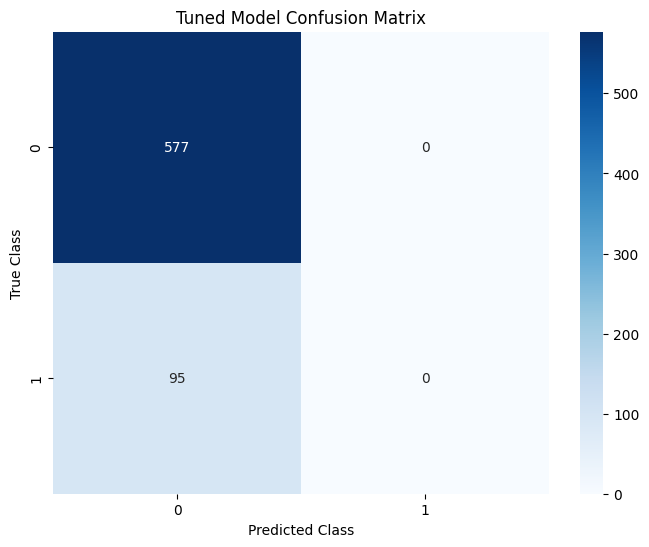

              precision    recall  f1-score   support

           0       0.86      1.00      0.92       577
           1       0.00      0.00      0.00        95

    accuracy                           0.86       672
   macro avg       0.43      0.50      0.46       672
weighted avg       0.74      0.86      0.79       672



/opt/homebrew/yes/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/homebrew/yes/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/homebrew/yes/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [195]:
from sklearn.metrics import classification_report

# Evaluate the model
y_pred_probs = best_model.predict(X_test)
y_pred = y_pred_probs.argmax(axis=1)

# Accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Tuned Model Test Accuracy: {accuracy * 100:.2f}%")

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Tuned Model Confusion Matrix')
plt.xlabel('Predicted Class')
plt.ylabel('True Class')
plt.show()

# Classification report
print(classification_report(y_test, y_pred))


/opt/homebrew/yes/lib/python3.10/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but PCA was fitted with feature names
  warnings.warn(


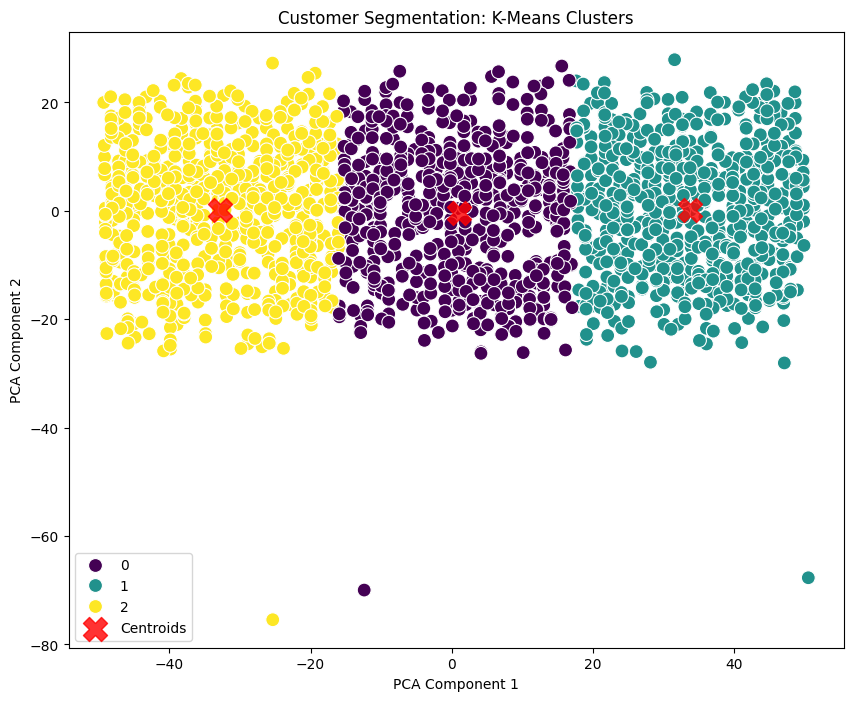

In [198]:
# Import necessary libraries for the purpose of how the clusters look like
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import seaborn as sns

# Assuming you've already built your K-Means model and predicted clusters
kmeans_model = build_kmeans_model(X, n_clusters=3)
cluster_labels = kmeans_model.predict(X)

# Apply PCA to reduce dimensions to 2D for visualization
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)  # X is your dataset after scaling

# Create a scatter plot to show the clusters
plt.figure(figsize=(10, 8))

# Plot the clusters with different colors
sns.scatterplot(x=X_pca[:, 0], y=X_pca[:, 1], hue=cluster_labels, palette='viridis', s=100)

# Plot the cluster centers
centers_pca = pca.transform(kmeans_model.cluster_centers_)
plt.scatter(centers_pca[:, 0], centers_pca[:, 1], c='red', s=300, alpha=0.8, marker='X', label='Centroids')

plt.title('Customer Segmentation: K-Means Clusters')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.legend()
plt.show()

